## Import

In [1]:
import torch
import torch.nn as nn

In [2]:
embed_dim = 72

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=76):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.n_patches = (img_size // patch_size)**2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size= patch_size, stride=patch_size,)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

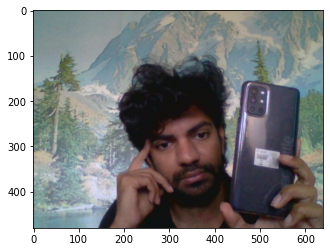

In [4]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms   

img = cv2.imread("img1.jpg")
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize((224, 224))])
img_resize = trans(img)
channels, height, width = img_resize.shape
img_show = img_resize.permute(1,2,0).numpy()
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img_resize.permute(1,2,0).numpy())
plt.imshow(img_show)

In [5]:
patch = PatchEmbed(img_size=height, embed_dim = embed_dim, patch_size = 16)
patches = patch(img_resize.unsqueeze(0))

shape of image 224 and size of patches is 16 and number of patches is 196 that is 14.0*14.0
Feature Maps of the patches created **unflattened for visualization


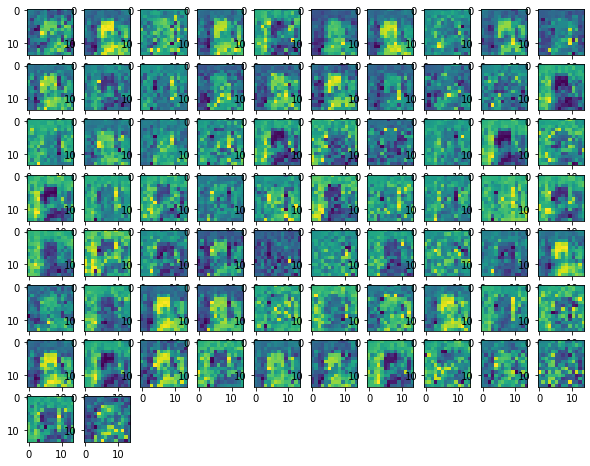

In [6]:
print(f"shape of image {patch.img_size} and size of patches is {patch.patch_size} and number of patches is {patch.n_patches} that is {patch.n_patches**0.5}*{patch.n_patches**0.5}")
print("Feature Maps of the patches created **unflattened for visualization")

from utils import plot_patches

plot_patches(patch, patches, embed_dim)
# plt.figure(figsize=(10,10)) # specifying the overall grid size
# the_array = patches.permute(2,1,0).detach().numpy()
# for i in range(embed_dim):
#     arr = the_array[i].reshape(int(patch.n_patches**0.5), int(patch.n_patches**0.5),1)
#     plt.subplot(10,10,i+1)    # the number of images in the grid is 5*5 (25)
#     plt.imshow(arr)
# plt.show()

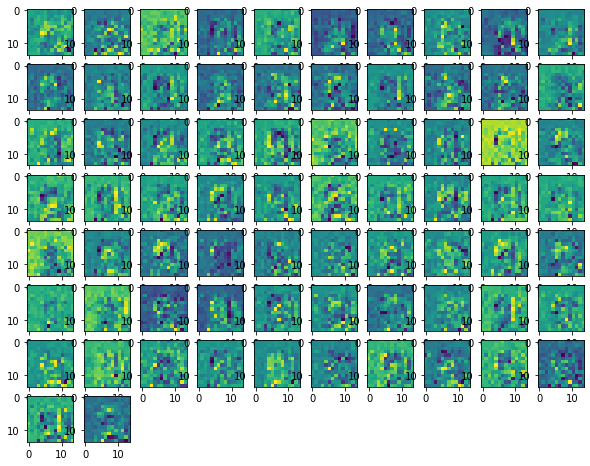

In [7]:
norm = nn.LayerNorm(embed_dim, elementwise_affine=False)
patches = norm(patches)
plot_patches(patch, patches, embed_dim)

# plt.figure(figsize=(10,10))
# the_array = patches.permute(2,1,0).detach().numpy()
# for i in range(embed_dim):
#     arr = the_array[i].reshape(int(patch.n_patches**0.5), int(patch.n_patches**0.5),1)
#     plt.subplot(10,10,i+1)    # the number of images in the grid is 5*5 (25)
#     plt.imshow(arr)
# plt.show()


#### Attention Mechanism

In [9]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12,qkv_bias = True, attn_p = 0., proj_p=0. ):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim*3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_p)
    
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape # (n_samples, n_patches+1, dim)
        # if dim != self.dim:
        #     raise ValueError
        qkv = self.qkv(x) # (n_samples, n_patches+1, 3*dim)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2,0,3,1,4) # (3,n_samples, n_heads, n_patches+1, head_dim)
        q,k,v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)
        dp = (q @ k_t ) * self.scale # (n_samples, n_heads, n_patches+1, n_patches+1)
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1,2) # (n_samples, n_patches+1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches+1, dim) same as input
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

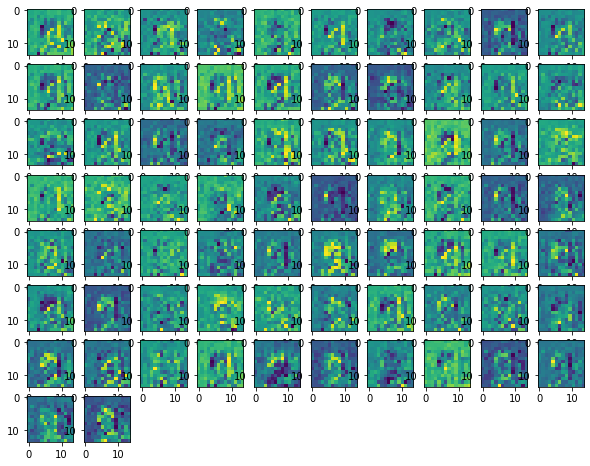

In [10]:
attention = Attention(dim=embed_dim)
attn = attention(patches)
plot_patches(patch, attn, embed_dim)


In [11]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [12]:
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio = 4.0, qkv_bias = True, p=0., attn_p=0.):
        super(Block, self).__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads=n_heads,qkv_bias = qkv_bias, attn_p = attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim*mlp_ratio)
        self.mlp = MLP(in_features = dim, hidden_features = hidden_features, out_features=dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        # x = self.attn(self.norm1(x))
        # x = self.mlp(self.norm2(x))
        return x

In [13]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size = 384, patch_size = 16, in_chans=3, n_classes=1000, embed_dim=768, 
                                    depth=12, n_heads=12, mlp_ratio=4., qkv_bias=True, p=0.,attn_p=0.):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbed(img_size=img_size,in_chans=in_chans, embed_dim = embed_dim, patch_size = patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,1+self.patch_embed.n_patches,embed_dim))
        self.blocks = nn.ModuleList([Block(
                        dim= embed_dim, n_heads=n_heads, mlp_ratio = mlp_ratio, qkv_bias = qkv_bias, p=p, attn_p=attn_p
        )
        for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples,-1,-1)
        x = torch.cat((cls_token,x), dim=1)
        x = x + self.pos_embed
        # x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:,0]
        x = self.head(cls_token_final)
        return x

In [14]:
model = VisionTransformer(img_size =224)

In [15]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/ViT')

In [16]:
img = img_resize.unsqueeze(dim=0)
writer.add_graph(model, img)
writer.close()

In [17]:
from torchvision.models.feature_extraction import get_graph_node_names
nodes, _ = get_graph_node_names(model)
print(nodes)

['x', 'getattr', 'getitem', 'patch_embed.proj', 'patch_embed.flatten', 'patch_embed.transpose', 'cls_token', 'expand', 'cat', 'pos_embed', 'add', 'blocks.0.norm1', 'blocks.0.attn.getattr', 'blocks.0.attn.getitem', 'blocks.0.attn.getitem_1', 'blocks.0.attn.getitem_2', 'blocks.0.attn.qkv', 'blocks.0.attn.reshape', 'blocks.0.attn.permute', 'blocks.0.attn.getitem_3', 'blocks.0.attn.getitem_4', 'blocks.0.attn.getitem_5', 'blocks.0.attn.transpose', 'blocks.0.attn.matmul', 'blocks.0.attn.mul', 'blocks.0.attn.softmax', 'blocks.0.attn.attn_drop', 'blocks.0.attn.matmul_1', 'blocks.0.attn.transpose_1', 'blocks.0.attn.flatten', 'blocks.0.attn.proj', 'blocks.0.attn.proj_drop', 'blocks.0.add', 'blocks.0.norm2', 'blocks.0.mlp.fc1', 'blocks.0.mlp.act', 'blocks.0.mlp.drop', 'blocks.0.mlp.fc2', 'blocks.0.mlp.drop_1', 'blocks.0.add_1', 'blocks.1.norm1', 'blocks.1.attn.getattr', 'blocks.1.attn.getitem', 'blocks.1.attn.getitem_1', 'blocks.1.attn.getitem_2', 'blocks.1.attn.qkv', 'blocks.1.attn.reshape', 'bl

In [18]:
nodes, _ = get_graph_node_names(model, tracer_kwargs={'leaf_modules': [Block]})
print(nodes)

['x', 'getattr', 'getitem', 'patch_embed.proj', 'patch_embed.flatten', 'patch_embed.transpose', 'cls_token', 'expand', 'cat', 'pos_embed', 'add', 'blocks.0', 'blocks.1', 'blocks.2', 'blocks.3', 'blocks.4', 'blocks.5', 'blocks.6', 'blocks.7', 'blocks.8', 'blocks.9', 'blocks.10', 'blocks.11', 'norm', 'getitem_1', 'head']


In [46]:
from torchvision.models.feature_extraction import create_feature_extractor
# Confused about the node specification here?
# We are allowed to provide truncated node names, and `create_feature_extractor`
# will choose the last node with that prefix.
feature_extractor = create_feature_extractor(
	model, return_nodes=['blocks.0', 'blocks.1', 'blocks.2', 'blocks.3'])
# `out` will be a dict of Tensors, each representing a feature map
out = feature_extractor(torch.zeros(1, 3, 224, 224))

In [47]:
block0 = out['blocks.0']

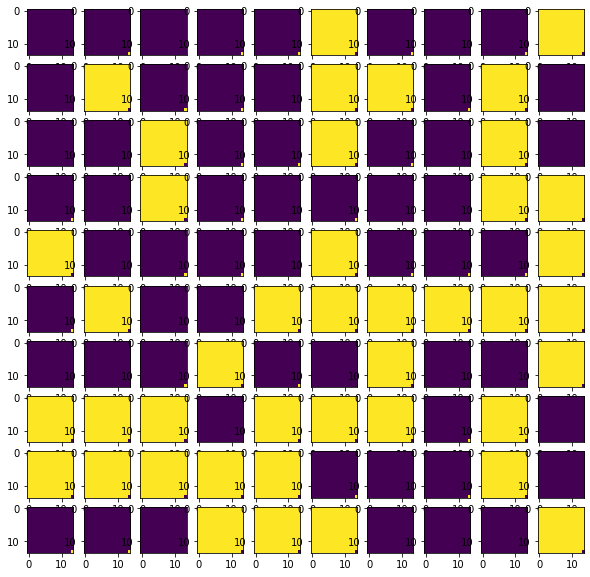

In [62]:
from utils import plot_features
plot_features(patch, block0)

In [76]:
import numpy as np
def gridarr(obj, patches):
    arr = []
    the_array = patches.permute(2,1,0).detach().numpy()
    for i in range(100):
        feature = np.split(the_array[i], [1,197])[1]
        arr.append(feature.reshape(int(obj.n_patches**0.5), int(obj.n_patches**0.5),1))
    return(torch.tensor(arr))

In [77]:
import torchvision


### Config Params

In [ ]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 
seed = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

### Download data and Spitting them

In [ ]:
from utils import download_data
from utils import img_show

train_list, test_list = download_data(unzip=False)
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
#Splitting train and validation list
train_list, valid_list = train_test_split(train_list, test_size=0.2, stratify=labels, random_state=seed)
Print("Data Split for Train, Val, Test")
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

In [ ]:
from utils import CatsDogsDataset
from torch.utils.data import DataLoader, Dataset
#defining train, validation and test dataset

train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

#loading dataloader
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
#Defining labels
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
img_show(train_list, labels)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=lr) # optimizer

In [ ]:
from utils import train
for epoch in range(epochs):
    train(train_loader, valid_loader, device, model, criterion, optimizer, epoch)
    images = gridarr(patch, block0)
    grid = torchvision.utils.make_grid(images)
    writer.add_image('images', grid, 0)
    writer.close()
print("Training Complete")